                                               **Generative Adversarial Neural Network**  


1. import Dependencies and Setup Environment




In [31]:
!pip install --upgrade tensorflow keras


In [32]:
# Install and import dependencies
!pip install tensorflow tensorflow-datasets matplotlib


In [33]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2D, LeakyReLU, Dropout, Flatten, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
import os

In [34]:
# Enable GPU memory growth for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2. Data Preparation and Preprocessing

In [35]:
# Load the Fashion MNIST dataset
ds = tfds.load('fashion_mnist', split='train')


In [36]:
# Scale images between 0 and 1
def preprocess(data):
    image = data['image']
    return image / 255

In [37]:
# Preprocess, shuffle, batch, and prefetch the dataset
ds = ds.map(preprocess)
ds = ds.cache().shuffle(60000).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)


In [38]:
for data in ds.take(1):
    print(data)  # Check if the dataset outputs are valid


tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.      

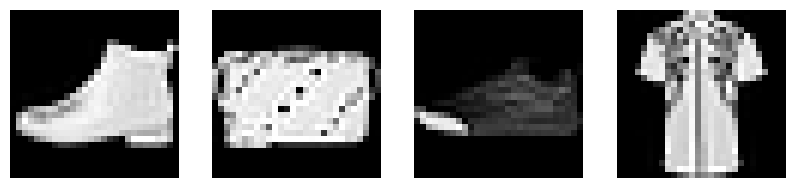

In [39]:
# Visualize sample images
data_iter = ds.as_numpy_iterator()
sample_batch = data_iter.next()
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
for idx, img in enumerate(sample_batch[:4]):
    ax[idx].imshow(np.squeeze(img), cmap='gray')
    ax[idx].axis('off')
plt.show()


3. Define Generator
The generator transforms random noise into images using upsampling and convolution layers.

In [41]:
def build_generator(latent_dim=128):
    model = Sequential()
    model.add(Dense(7 * 7 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, kernel_size=7, padding='same', activation='sigmoid'))
    return model

generator = build_generator()
generator.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 1)           │           3,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,426,817 (5.44 MB)

 Trainable params: 1,426,817 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

4. Define Discriminator
The discriminator classifies images as real or fake.

In [42]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

5. Combine into GAN Model
Define the GAN class that handles training for both the generator and discriminator.

In [43]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
        fake_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, fake_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the generator
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}


# Instantiate the GAN model
gan = GAN(generator, discriminator)

6. Compile and Train

In [44]:
# Optimizers and Losses
g_optimizer = Adam(learning_rate=0.0001)
d_optimizer = Adam(learning_rate=0.0001)
loss_fn = BinaryCrossentropy()


In [45]:
# Compile the model
gan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer, g_loss_fn=loss_fn, d_loss_fn=loss_fn)

In [46]:
from tensorflow.keras.callbacks import Callback

class DebugCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch}: logs = {logs}")

callbacks = [DebugCallback()]
gan.fit(ds, epochs=5, callbacks=callbacks)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - d_loss: 6.7804 - g_loss: 1.7055Epoch 0: logs = {'d_loss': -0.008941248059272766, 'g_loss': 2.6493303775787354}
469/469 ━━━━━━━━━━━━━━━━━━━━ 3863s 8s/step - d_loss: 6.7659 - g_loss: 1.7075
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - d_loss: -0.1010 - g_loss: 3.1994Epoch 1: logs = {'d_loss': -0.14164459705352783, 'g_loss': 3.522599220275879}
469/469 ━━━━━━━━━━━━━━━━━━━━ 3899s 8s/step - d_loss: -0.1010 - g_loss: 3.2001
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - d_loss: 1.0274 - g_loss: 1.8980Epoch 2: logs = {'d_loss': 0.49549344182014465, 'g_loss': 1.004841685295105}
469/469 ━━━━━━━━━━━━━━━━━━━━ 3862s 8s/step - d_loss: 1.0263 - g_loss: 1.8961
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - d_loss: 0.6399 - g_loss: 0.9187Epoch 3: logs = {'d_loss': 0.8575019836425781, 'g_loss': 0.5438470244407654}
469/469 ━━━━━━━━━━━━━━━━━━━━ 3834s 8s/step - d_loss: 0.6403 - g_loss: 0.9179
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/s

7. Generate and Visualize Images

In [47]:
# Generate new images after training
random_latent_vectors = tf.random.normal(shape=(16, 128))
generated_images = generator.predict(random_latent_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


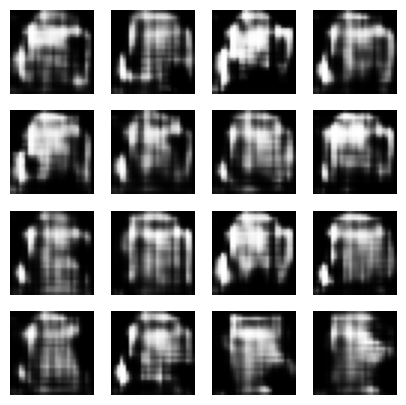

In [50]:


# Plot generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(5, 5))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(generated_images[i * 4 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')
plt.show()


Explanation:

Generator
 creates new images from random noise.
Discriminator
 classifies images as real or fake.
GAN
 ties both together, training them in tandem.
Training loop
 ensures discriminator improves at distinguishing
  while generator learns to "fool" it.
Visualization
 shows progress in generating realistic images.